In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
from PIL import Image
import cv2
import math
from google.colab.patches import cv2_imshow
import torchvision.transforms as transforms

In [49]:
class LightFilter(object):
    def __init__(self, size, data_path, image_path, brightness_limit1, brightness_limit2, mask_size1, mask_size2, shift_x, shift_y, angle):
        self.size = size
        self.data_path = data_path
        self.image_path = image_path
        self.brightness_limit1 = brightness_limit1
        self.brightness_limit2 = brightness_limit2
        self.mask_size1 = mask_size1
        self.mask_size2 = mask_size2
        self.shift_x = shift_x
        self.shift_y = shift_y
        self.angle = angle


    def compression_stretching(self, mask):
        """ compresses or stretches the mask to the specified size """
        pad1 = (self.size[0]- self.mask_size1)
        pad2 = (self.size[1]- self.mask_size2)
        transform = transforms.Pad((math.ceil((self.size[0]- self.mask_size1 )/2 ) , math.ceil((self.size[1]- self.mask_size2 )/2 ) ),fill = 0, padding_mode = 'constant')
        if (abs(pad1/2 - math.ceil(pad1/2)) == 0.5):
          mask_size1_ = self.mask_size1 - 1
        else:
          mask_size1_ = self.mask_size1
        if (abs(pad2/2 - math.ceil(pad2/2)) == 0.5):
          mask_size2_ = self.mask_size2 - 1
        else:
          mask_size2_ = self.mask_size2
        resized_image = cv2.resize(mask, (mask_size1_, mask_size2_), fx = 1, fy = 1, interpolation = None)
        pil_image=Image.fromarray(resized_image)
        pil_image = transform(pil_image)
        img = np.array(pil_image)
        img = img[:,:,np.newaxis]
        return(img)

    def changing_mask_center(self, mask):
        """ shifts the center of the mask by a specified number of pixels, 
        the center of the image is taken as the starting point """
        M = np.float32([[1, 0, self.shift_x], [0, 1, self.shift_y]])
        (rows, cols) = mask.shape[:2]
        res = cv2.warpAffine(mask, M, (cols, rows))
        res = res[:,:,np.newaxis]
        return(res)

    
    def mask_preparation(self):
        """ creates a distribution mask from a file, normalizing the original values """
        data = pd.read_csv(self.data_path, sep=" ", header=None)
        minimal_el = data.min(axis = 1).min()
        max_el = data.max(axis = 1).max()
        data = (data - minimal_el)/(max_el - minimal_el)
        mask = data.to_numpy()
        mask = np.array(Image.fromarray(mask).resize(self.size, Image.BILINEAR))
        mask = mask[:,:,np.newaxis]
        return(mask)

    
    def bright_image(self):
        """ creates a fully illuminated image using augmentation RandomBrightnessContrast  """
        img = Image.open(self.image_path)
        out = img.resize(self.size)
        img_np = np.array(out)
        image = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
        transform = A.Compose([ A.RandomBrightnessContrast(always_apply= True, p=1.0, brightness_limit=(self.brightness_limit1, self.brightness_limit2), contrast_limit=(1.0, 1.0))])
        transformed = transform(image=image)
        src_light = transformed['image']
        src_light_  = cv2.cvtColor(src_light, cv2.COLOR_RGB2BGR)
        return(src_light_)

    def mask_rotation(self, mask):
        """ rotates the mask by the specified angle """
        (rows, cols) = mask.shape[:2]
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), self.angle, 1)
        res = cv2.warpAffine(mask, M, (cols, rows))
        res = res[:,:,np.newaxis]
        return(res)


    def final_image(self,  mask, src_light, src1):
        """ applies a mask according to the formula below, saves the final image """
        dst = src_light * mask + src1 * (1 - mask)
        Image.fromarray(dst.astype(np.uint8)).save('final.jpg')
        image = Image.open('final.jpg')
        np_array_img = np.array(image)
        return(np_array_img)

  
    def initial_picture(self):
        """ brings the original image to the desired size and returns it as np.array """
        img = Image.open(self.image_path)
        out = img.resize(self.size)
        img_np = np.array(out)
        return(img_np)

# LightFilter arguments:     

1.   size: (width, height) - the number of pixels of image
2.   data_path : path to dataset with data distribution
3.   image_path: path to the image 
4.   brightness_limit1: first limit for range for changing brightness
5.   brightness_limit2: second limit for range for changing brightness 
6.   mask_size1: specified width of mask
7.   mask_size2: specified height of mask
8.   shift_x: shift of mask on x-axis from the center of image
9.   shift_y: shift of mask on y-axis from the center of image
10.  angle: the angle of rotation of mask (in range(0, 360))



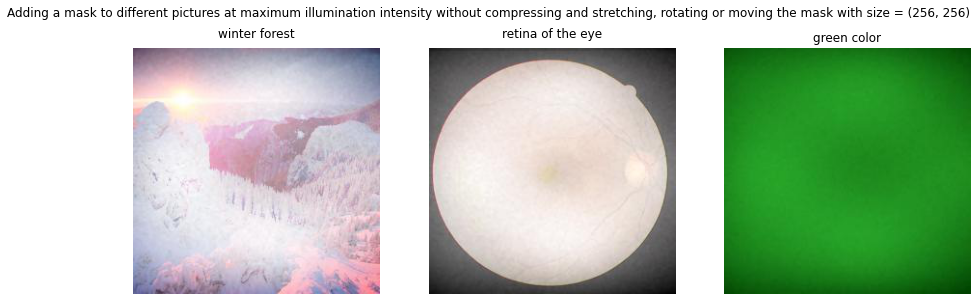

In [83]:
ex1 = LightFilter((256,256), "detector-data-100m.txt", "photo2.jpg", 1, 1 , 256, 256, 0, 0, 0)
ex2 = LightFilter((256,256), "detector-data-100m.txt", "vein.png", 1, 1 , 256, 256, 0, 0, 0)
ex3 = LightFilter((256,256), "detector-data-100m.txt", "green.png", 1, 1 , 256, 256, 0, 0, 0)
pic1 = ex1.final_image(ex1.mask_preparation(), ex1.bright_image(), ex1.initial_picture())
pic2 = ex2.final_image(ex2.mask_preparation(), ex2.bright_image(), ex2.initial_picture())
pic3 = ex3.final_image(ex3.mask_preparation(), ex3.bright_image(), ex3.initial_picture())
pictures = [pic1, pic2, pic3]
pic_box = plt.figure(figsize=(15,15))
names = ['winter forest','retina of the eye','green color']

for i, picture in enumerate(pictures):
    pic_box.add_subplot(1,3,i+1)
    plt.imshow(picture)
    plt.title(label=names[i], pad=10)
    plt.axis('off')
  
plt.title(y = 1.1, loc = 'right', label = "Adding a mask to different pictures at maximum illumination intensity without compressing and stretching, rotating or moving the mask with size = (256, 256)")
plt.show() 


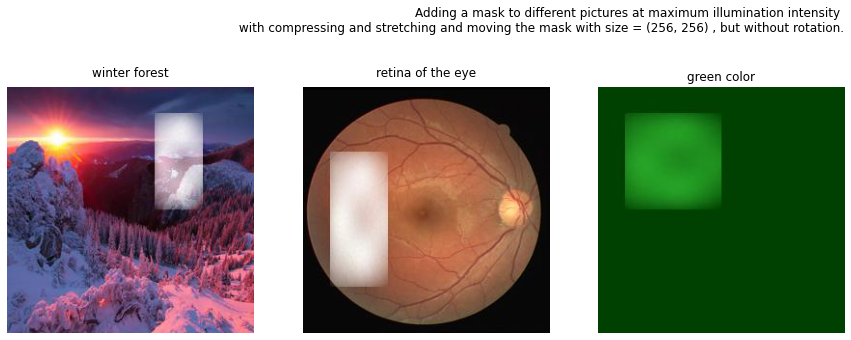

In [84]:
ex1 = LightFilter((256,256), "detector-data-100m.txt", "photo2.jpg", 1, 1 , 50, 100, 50, -50, 0)
ex2 = LightFilter((256,256), "detector-data-100m.txt", "vein.png", 1, 1 , 60, 140, -70, 10, 0)
ex3 = LightFilter((256,256), "detector-data-100m.txt", "green.png", 1, 1 , 100, 100, -50, -50, 0)
pic1 = ex1.final_image(ex1.changing_mask_center(ex1.compression_stretching(ex1.mask_preparation())), 
                       ex1.bright_image(), ex1.initial_picture())
pic2 = ex2.final_image(ex2.changing_mask_center(ex2.compression_stretching(ex2.mask_preparation())), 
                       ex2.bright_image(), ex2.initial_picture())
pic3 = ex3.final_image(ex3.changing_mask_center(ex3.compression_stretching(ex3.mask_preparation())), 
                       ex3.bright_image(), ex3.initial_picture())
pictures = [pic1, pic2, pic3]
pic_box = plt.figure(figsize=(15,15))
names = ['winter forest','retina of the eye','green color']

for i, picture in enumerate(pictures):
    pic_box.add_subplot(1,3,i+1)
    plt.imshow(picture)
    plt.title(label=names[i], pad=10)
    plt.axis('off')
  
plt.title(y = 1.2, loc = 'right', label = "Adding a mask to different pictures at maximum illumination intensity \n with compressing and stretching and moving the mask with size = (256, 256) , but without rotation.")
plt.show() 

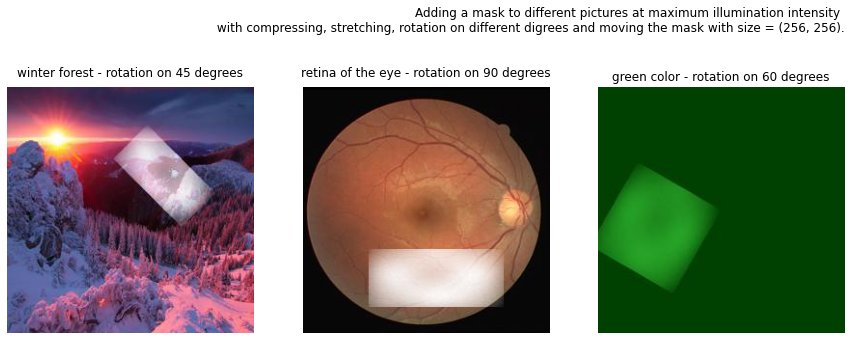

In [89]:
ex1 = LightFilter((256,256), "detector-data-100m.txt", "photo2.jpg", 1, 1 , 50, 100, 50, 0, 45)
ex2 = LightFilter((256,256), "detector-data-100m.txt", "vein.png", 1, 1 , 60, 140, -70, 10, 90)
ex3 = LightFilter((256,256), "detector-data-100m.txt", "green.png", 1, 1 , 100, 100, -50, -50, 60)
pic1 = ex1.final_image(ex1.mask_rotation(ex1.changing_mask_center(ex1.compression_stretching(ex1.mask_preparation()))),
                       ex1.bright_image(), ex1.initial_picture())
pic2 = ex2.final_image(ex2.mask_rotation(ex2.changing_mask_center(ex2.compression_stretching(ex2.mask_preparation()))), 
                       ex2.bright_image(), ex2.initial_picture())
pic3 = ex3.final_image(ex3.mask_rotation(ex3.changing_mask_center(ex3.compression_stretching(ex3.mask_preparation()))), 
                       ex3.bright_image(), ex3.initial_picture())
pictures = [pic1, pic2, pic3]
pic_box = plt.figure(figsize=(15,15))
names = ['winter forest - rotation on 45 degrees','retina of the eye - rotation on 90 degrees',
         'green color - rotation on 60 degrees']

for i, picture in enumerate(pictures):
    pic_box.add_subplot(1,3,i+1)
    plt.imshow(picture)
    plt.title(label=names[i], pad=10)
    plt.axis('off')
  
plt.title(y = 1.2, loc = 'right',
label = "Adding a mask to different pictures at maximum illumination intensity \n with compressing, stretching, rotation on different digrees and moving the mask with size = (256, 256).")
plt.show() 